<a href="https://colab.research.google.com/github/sky1113/CIS4190/blob/main/skylar_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing dependencies

Please make a copy of this notebook.


In [ ]:
!pip install geopy > delete.txt
!pip install datasets > delete.txt
!pip install torch torchvision datasets > delete.txt
!pip install huggingface_hub > delete.txt
!rm delete.txt

# Huggingface login
You will require your personal token.

In [ ]:
!huggingface-cli login

# Data

## Downloading the train and test dataset

In [ ]:
from datasets import load_dataset, Image

dataset_train = load_dataset("CIS-5190-Final-Project/Images", split="train")
dataset_test = load_dataset("CIS-5190-Final-Project/Images", split="test")

In [ ]:
print(dataset_train)
print(dataset_test)

## Defining the Custom Dataset Class

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from transformers import AutoImageProcessor, AutoModelForImageClassification
from huggingface_hub import PyTorchModelHubMixin
from PIL import Image
import os
import numpy as np

class CustomResNetModel(nn.Module, PyTorchModelHubMixin):
    def __init__(self, model_name="microsoft/resnet-18", num_classes=2):
        super().__init__()

        # Load pre-trained ResNet model from Hugging Face
        self.resnet = AutoModelForImageClassification.from_pretrained(model_name)

        # Access the Linear layer within the Sequential classifier
        in_features = self.resnet.classifier[1].in_features  # Accessing the Linear layer within the Sequential

        # Modify the classifier layer to have the desired number of output classes
        self.resnet.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

    def save_model(self, save_path):
        """Save model locally using the Hugging Face format."""
        self.save_pretrained(save_path)

    def push_model(self, repo_name):
        """Push the model to the Hugging Face Hub."""
        self.push_to_hub(repo_name)

class GPSImageDataset(Dataset):
    def __init__(self, hf_dataset, transform=None, lat_mean=None, lat_std=None, lon_mean=None, lon_std=None):
        self.hf_dataset = hf_dataset
        self.transform = transform

        # Compute mean and std from the dataframe if not provided
        self.latitude_mean = lat_mean if lat_mean is not None else np.mean(np.array(self.hf_dataset['Latitude']))
        self.latitude_std = lat_std if lat_std is not None else np.std(np.array(self.hf_dataset['Latitude']))
        self.longitude_mean = lon_mean if lon_mean is not None else np.mean(np.array(self.hf_dataset['Longitude']))
        self.longitude_std = lon_std if lon_std is not None else np.std(np.array(self.hf_dataset['Longitude']))

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        # Extract data
        example = self.hf_dataset[idx]

        # Load and process the image
        image = example['image']
        latitude = example['Latitude']
        longitude = example['Longitude']
        # image = image.rotate(-90, expand=True)
        if self.transform:
            image = self.transform(image)

        # Normalize GPS coordinates
        latitude = (latitude - self.latitude_mean) / self.latitude_std
        longitude = (longitude - self.longitude_mean) / self.longitude_std
        gps_coords = torch.tensor([latitude, longitude], dtype=torch.float32)

        return image, gps_coords

## Creating dataloaders and visualizing the data

In [ ]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Random crop and resize to 224x224
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(degrees=15),  # Random rotation between -15 and 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Optionally, you can create a separate transform for inference without augmentations
inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])



# Create the training dataset and dataloader
train_dataset = GPSImageDataset(hf_dataset=dataset_train, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Retrieve normalization parameters from the training dataset
lat_mean = train_dataset.latitude_mean
lat_std = train_dataset.latitude_std
lon_mean = train_dataset.longitude_mean
lon_std = train_dataset.longitude_std

# Create the validation dataset and dataloader using training mean and std
val_dataset = GPSImageDataset(
    hf_dataset=dataset_test,
    transform=inference_transform,
    lat_mean=lat_mean,
    lat_std=lat_std,
    lon_mean=lon_mean,
    lon_std=lon_std
)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
# Verify loading
for images, gps_coords in train_dataloader:
    print(images.size(), gps_coords.size())
    break

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np

def denormalize(tensor, mean, std):
    mean = np.array(mean)
    std = np.array(std)
    tensor = tensor.numpy().transpose((1, 2, 0))  # Convert from C x H x W to H x W x C
    tensor = std * tensor + mean  # Denormalize
    tensor = np.clip(tensor, 0, 1)  # Clip to keep pixel values between 0 and 1
    return tensor

data_iter = iter(train_dataloader)
images, gps_coords = next(data_iter)  # Get a batch of images and labels
# Denormalize the first image in the batch for display
itr = 0
for im in images:
  image = denormalize(im, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

  # Plot the image
  plt.imshow(image)
  plt.title(f'Latitude: {gps_coords[itr][0].item():.4f}, Longitude: {gps_coords[itr][1].item():.4f}')
  plt.axis('off')
  plt.show()
  itr += 1

# Resnet

In [ ]:
import torch.nn as nn
import torch.optim as optim
from geopy.distance import geodesic
from torch.optim.lr_scheduler import ReduceLROnPlateau
from transformers import AutoImageProcessor, AutoModelForImageClassification

# Load the pre-trained ResNet18 model
resnet = models.resnet18(pretrained=False)

# Modify the last fully connected layer to output 2 values (latitude and longitude)
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, 2)  # Latitude and Longitude

# Not freeze pre-trained weights (excluding the final layer)
for param in resnet.parameters():
    param.requires_grad = True

for param in resnet.fc.parameters():
    param.requires_grad = True

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(resnet.parameters(), lr=0.0001, weight_decay=1e-4)

# Use ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')
resnet = resnet.to(device)

# Training loop with validation
num_epochs = 5
for epoch in range(num_epochs):
    resnet.train()
    running_loss = 0.0
    for images, gps_coords in train_dataloader:
        images, gps_coords = images.to(device), gps_coords.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet(images)
        loss = criterion(outputs, gps_coords)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_dataloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_loss:.4f}")

    # Validation phase
    resnet.eval()
    val_loss = 0.0
    baseline_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for images, gps_coords in val_dataloader:
            images = images.to(device)
            gps_coords = gps_coords.to(device)

            batch_size = gps_coords.size(0)
            total_samples += batch_size

            # Model predictions
            outputs = resnet(images)

            # Denormalize predictions and actual GPS coordinates
            preds_denorm = outputs.cpu().numpy() * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])
            actuals_denorm = gps_coords.cpu().numpy() * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])

            # Compute geodesic distances between predictions and actuals
            for pred, actual in zip(preds_denorm, actuals_denorm):
                distance = geodesic((actual[0], actual[1]), (pred[0], pred[1])).meters
                val_loss += distance ** 2  # Squared distance

            # Baseline predictions
            baseline_preds = np.array([lat_mean, lon_mean])

            # Compute geodesic distances between baseline preds and actuals
            for actual in actuals_denorm:
                distance = geodesic((actual[0], actual[1]), (baseline_preds[0], baseline_preds[1])).meters
                baseline_loss += distance ** 2  # Squared distance

    # Compute average losses
    val_loss /= total_samples
    baseline_loss /= total_samples

    # Compute RMSE
    val_rmse = np.sqrt(val_loss)
    baseline_rmse = np.sqrt(baseline_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss (meters^2): {val_loss:.2f}, Baseline Loss (meters^2): {baseline_loss:.2f}")
    print(f"Epoch [{epoch + 1}/{num_epochs}], Validation RMSE (meters): {val_rmse:.2f}, Baseline RMSE (meters): {baseline_rmse:.2f}")

    # Update the scheduler with the validation metric (choose one - val_loss or val_rmse)
    scheduler.step(val_loss)  # Using val_loss as the metric to reduce learning rate

print('Training complete')

# Save the trained model
torch.save(resnet.state_dict(), 'resnet_gps_regressor.pth')

# Testing the learnt model

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Initialize lists to store predictions and actual values
all_preds = []
all_actuals = []

resnet.eval()
with torch.no_grad():
    for images, gps_coords in val_dataloader:
        images, gps_coords = images.to(device), gps_coords.to(device)

        outputs = resnet(images)

        # Denormalize predictions and actual values
        preds = outputs.cpu() * torch.tensor([lat_std, lon_std]) + torch.tensor([lat_mean, lon_mean])
        actuals = gps_coords.cpu() * torch.tensor([lat_std, lon_std]) + torch.tensor([lat_mean, lon_mean])

        all_preds.append(preds)
        all_actuals.append(actuals)

# Concatenate all batches
all_preds = torch.cat(all_preds).numpy()
all_actuals = torch.cat(all_actuals).numpy()

# Compute error metrics
mae = mean_absolute_error(all_actuals, all_preds)
rmse = mean_squared_error(all_actuals, all_preds, squared=False)

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')

NameError: name 'resnet' is not defined

In [ ]:
import numpy as np

# Retrieve normalization parameters from the training dataset
lat_mean = train_dataset.latitude_mean
lat_std = train_dataset.latitude_std
lon_mean = train_dataset.longitude_mean
lon_std = train_dataset.longitude_std

# Denormalize predictions and actual values
all_preds_denorm = all_preds * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])
all_actuals_denorm = all_actuals * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])

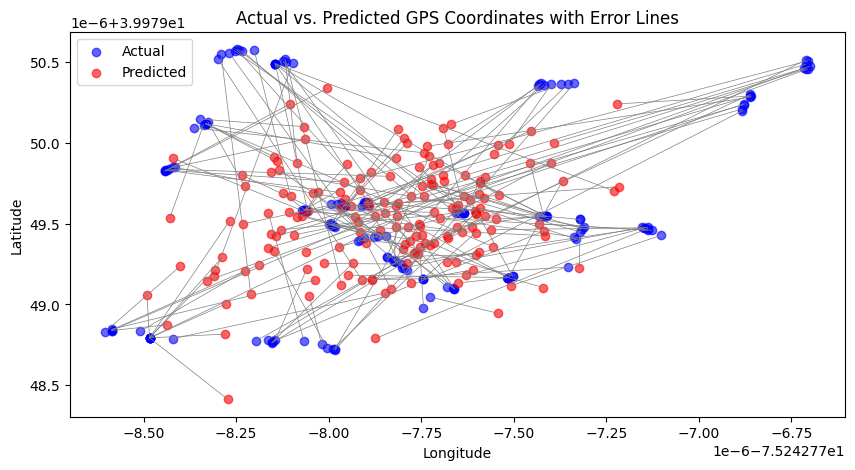

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Plot actual points
plt.scatter(all_actuals_denorm[:, 1], all_actuals_denorm[:, 0], label='Actual', color='blue', alpha=0.6)

# Plot predicted points
plt.scatter(all_preds_denorm[:, 1], all_preds_denorm[:, 0], label='Predicted', color='red', alpha=0.6)

# Draw lines connecting actual and predicted points
for i in range(len(all_actuals_denorm)):
    plt.plot(
        [all_actuals_denorm[i, 1], all_preds_denorm[i, 1]],
        [all_actuals_denorm[i, 0], all_preds_denorm[i, 0]],
        color='gray', linewidth=0.5
    )

plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Actual vs. Predicted GPS Coordinates with Error Lines')
plt.show()

# 1. Pushing the Modle to the Hugging Face(HF Model)

Use this code if you loaded model from Hugging Face

In [ ]:
resnet.push_to_hub("CIS-5190-Final-Project/baseline_model_first")

You load this model by running

In [ ]:
from huggingface_hub import HfApi, Repository, snapshot_download

# Initialize HfApi
api = HfApi()

# modify repo_name if necessary
repo_name = "CIS-5190-Final-Project/baseline_model_first" # Adjust repo name as needed

# Create or get the repository
repo_url = api.create_repo(repo_id=repo_name, exist_ok=True)

# Save the model locally first
torch.save(resnet, "resnet_gps_regressor.pth")  # Or your desired local path

# Upload the model to the Hub
api.upload_file(
    path_or_fileobj="resnet_gps_regressor.pth",
    path_in_repo="resnet_gps_regressor.pth",  # You can change the filename on the Hub
    repo_id=repo_name,
    repo_type="model",
)

In [ ]:
model=CustomResNetModel.from_pretrained("CIS-5190-Final-Project/Images/baseline_model_first")

# 2. Pushing the model to the Hugging Face (Torchvision Model)

Use this code if you loaded the model from Torchvision or built the model from scratch using PyTorch. If you built your model from scratch, make sure to follow the guidelines described here - https://huggingface.co/docs/hub/en/models-uploading#upload-a-pytorch-model-using-huggingfacehub


In [ ]:
path_name = "resnet_gps_regressor_complete.pth"
model_save_path = "/content/resnet_gps_regressor_complete.pth"
torch.save(resnet, model_save_path)

In [ ]:
from huggingface_hub import HfApi, Repository

# Initialize HfApi
api = HfApi()

# modify repo_name if necessary
repo_name = "ImageToGPSproject_base_resnet18"
organization_name = "{YOUR ORGANIZATION NAME}"
repo_url = api.create_repo(repo_id=f"{organization_name}/{repo_name}", exist_ok=True)

In [ ]:
repo_local_dir = "/content/ImageToGPSproject_base_resnet18"
repo = Repository(local_dir=repo_local_dir, clone_from=repo_url)

In [ ]:
os.rename(model_save_path, f"{repo_local_dir}/resnet_gps_regressor_complete.pth")

In [ ]:
!git config --global user.email "{YOUR HUGGINGFACE EMAIL}"
!git config --global user.name "{YOUR HUGGINGFACE USERNAME}"

In [ ]:
repo.push_to_hub(commit_message="Add fine-tuned ResNet18 model for Image to GPS project")

You load this model by running

In [ ]:
from huggingface_hub import hf_hub_download
import torch

# Specify the repository and the filename of the model you want to load
repo_id = "{organization_name}/{repo_name}"  # Replace with your repo name
filename = "{path_name}"

model_path = hf_hub_download(repo_id=repo_id, filename=filename)

# Load the model using torch
model_test = torch.load(model_path)
model_test.eval()  # Set the model to evaluation mode